In [29]:
import pandas as pd
import os
script_dir = '/home/local/PSYCH-ADS/xuqian_chen/Github/effective-altruism/1_code'
data_folder_path = os.path.join(os.path.dirname(script_dir),'0_data')
pipeline_folder_path = os.path.join(os.path.dirname(script_dir),'2_pipeline/preprocessed')
tmp_folder_path =os.path.join(os.path.dirname(script_dir), '2_pipeline/tmp')

d = pd.read_excel(os.path.join(data_folder_path, 'combined_groups_alldata_LU_update.xlsx'), sheet_name="complete")
dfintake = pd.read_excel(os.path.join(data_folder_path, 'combined_groups_alldata_LU_update.xlsx'),sheet_name="no empty entries")
df = pd.merge(d, dfintake, on='participant_ID', how='left')

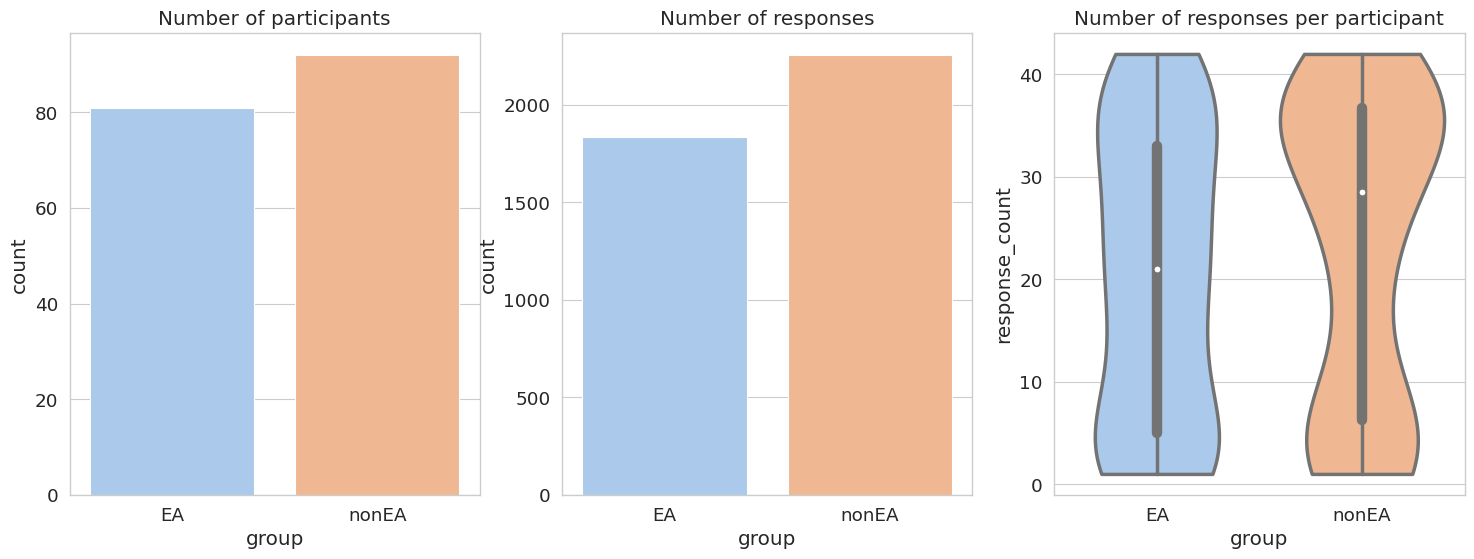

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
# set sns style
sns.color_palette("colorblind")

# Count number of responses per participant within each group
response_counts = df.groupby(['group', 'participant_ID']).size().reset_index(name='response_count')

# Create two count plot for the 'group' variable, one is df, one is dfintake; plus a frequency plot group by participant_ID, different color annotated group, for df
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.countplot(ax=axes[0], x='group', data=dfintake)
sns.countplot(ax=axes[1], x='group', data=d)
# plot violine plot for response_count, limit the min y to 0
sns.violinplot(ax=axes[2], x='group', y='response_count', data = response_counts, cut=0)

# set title
axes[0].set_title('Number of participants')
axes[1].set_title('Number of responses')
axes[2].set_title('Number of responses per participant')
plt.show()

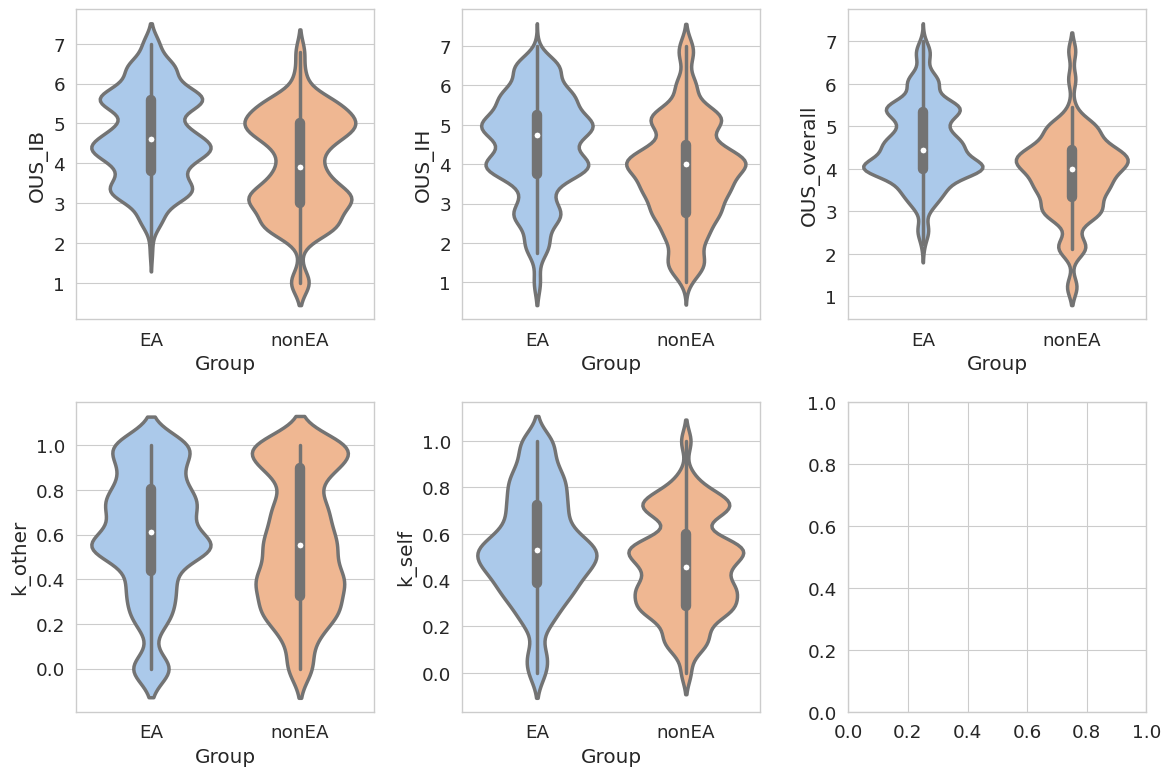

In [107]:

# plot ous variables historgrams across groups in 2 rows and 3 columns
ous_vars = ['OUS_IB', 'OUS_IH', 'OUS_overall', 'k_other', 'k_self']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    try:
        sns.violinplot(x='group', y=ous_vars[i], data=df, ax=ax)
    except:
        continue
    ax.set_xlabel('Group')
    ax.set_ylabel(ous_vars[i])
plt.tight_layout()
plt.show()

In [70]:
from scipy.stats import ttest_ind

group_EA = dfintake[dfintake['group'] == 'EA']
group_nonEA = dfintake[dfintake['group'] == 'nonEA']

for var in ous_vars:
    t_stat, p_val = ttest_ind(group_EA[var], group_nonEA[var], nan_policy='omit')
    mean_EA = round(group_EA[var].mean(), 2)
    mean_nonEA = round(group_nonEA[var].mean(), 2)
    if mean_EA > mean_nonEA:
        higher_group = "EA"
    else:
        higher_group = "nonEA"
    print(var, " | t_stat: ", round(t_stat, 2), "p_val: ", round(p_val, 2), "higher_group: ", higher_group)
    


OUS_IB  | t_stat:  3.76 p_val:  0.0 higher_group:  EA
OUS_IH  | t_stat:  3.07 p_val:  0.0 higher_group:  EA
OUS_overall  | t_stat:  4.49 p_val:  0.0 higher_group:  EA
k_other  | t_stat:  1.01 p_val:  0.32 higher_group:  EA
k_self  | t_stat:  2.15 p_val:  0.03 higher_group:  EA


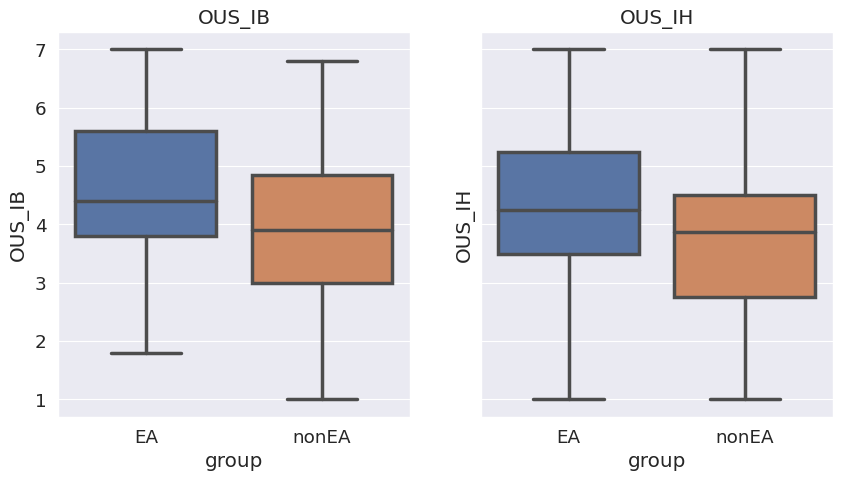

In [10]:
#find variable names containing OUS in dfintake 
OUS = [col for col in dfintake.columns if 'OUS' in col]
OUS

['OUS_IB',
 'OUS_IH',
 'OUS_1',
 'OUS_2',
 'OUS_3',
 'OUS_4',
 'OUS_5',
 'OUS_6',
 'OUS_7',
 'OUS_8',
 'OUS_9',
 'OUS_IB.1',
 'OUS_IH.1',
 'OUS_overall']